In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# November 2024

"""
Plot Figure 3,4,S3,S4 for Whillans Catalog Paper
Figure 3: Events on top of tides
Figure 4: 45-Day Rolling Mean
Figure S3: Events at different tides
Figure S4: 3-Day Rolling Mean
Figure S5: 27-Day Rolling Mean


v1.0: 01 November 2024
    Plots for Whillans Catalog Paper

"""

# Imports
import datetime
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


import pandas as pd
import numpy as np
import scipy


from pyproj import CRS, Transformer
import shapefile
import shapely
from shapely.plotting import plot_line
from shapely.geometry import LineString

from cmap import Colormap
import xarray as xr
import rasterio


sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Tides",
)
import Tides

%reload_ext autoreload
%autoreload


################################################################################
########################## User Defined Variables ##############################

min_stas = 2  # Which catalog to use
tide_dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

########################## User Defined Variables ##############################
################################################################################

In [2]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(f"../AllEventStartTimes_{min_stas}stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Load no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv(f"../no_data_{min_stas}stas.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff

In [3]:
# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 17.354166666666668, 21.766666666666666, 10.758333333333333, 13.254166666666666, 19.1125, 22.970833333333335, 10.4875, 11.895833333333334, 9.975, 14.345833333333333, 9.975, 14.845833333333333, 9.9875, 14.658333333333333, 12.0625, 13.1375, 9.808333333333334, 15.225, 10.9875, 14.591666666666667, 10.625, 15.1, 23.866666666666667, 8.416666666666666, 16.3375, 21.929166666666667, 10.666666666666666, 14.5875, 18.954166666666666, 14.941666666666666, 10.7375, 20.645833333333332, 13.025, 12.041666666666666, 11.0125, 13.125, 9.525, 15.145833333333334, 8.875, 15.625, 8.2875, 16.266666666666666, 8.525, 16.9125, 8.5125, 16.4875, 8.55, 19.804166666666667, 16.733333333333334, 11.6625, 12.2, 12.983333333333333, 13.9, 21.4, 20.2, 12.008333333333333, 11.979166666666666, 11.516666666666667, 12.891666666666667, 11.183333333333334, 13.1125, 11.1, 13.5125, 11.545833333333333, 13.420833333333333, 10.85, 14.083333333333334, 10.420833333333333, 14.325, 11.045833333333333, 16.941666666666666,

[(-174.11568595746584, -84.38504722396503), (-174.07363790894706, -84.38708087490528), (-174.03252834334145, -84.38929637003153), (-173.9941263318061, -84.39193572017322), (-173.95194821792526, -84.39181611372216), (-173.90710899077706, -84.39045168887456), (-173.86118811502547, -84.38949590176401), (-173.8148291962652, -84.38878233553352), (-173.76803047357416, -84.38841239171828), (-173.72112609045024, -84.38834365932638), (-173.6742274584149, -84.38855870689241), (-173.62764576571297, -84.38910967700275), (-173.5814536310214, -84.38993610577346), (-173.53591166420026, -84.3910466307691), (-173.49112552234823, -84.39243260584267), (-173.44773757602218, -84.39419044387766), (-173.40529722592322, -84.39616056496061), (-173.36429498918946, -84.39840763385244), (-173.32440343132876, -84.40084127031444), (-173.28402159579116, -84.40319834133297), (-173.24328319333878, -84.40550028801066), (-173.20251122152564, -84.4077994127134), (-173.16170568018524, -84.41009571193077), (-173.1203332639

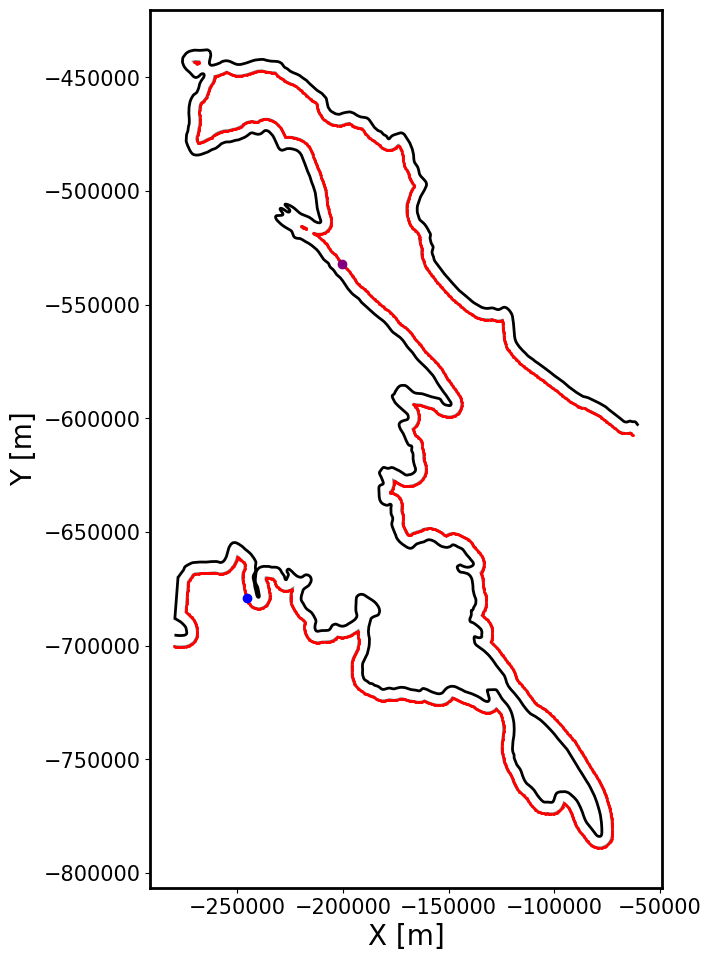

In [4]:
# Calculate difference in tides across basin at event times (from icesat2/gztides.ipynb)
# Helper functions
def inBox(points, bbox):
    # Return points from points that are in bbox
    inbox = []
    for point in points:
        x = point[0]
        y = point[1]
        if x > bbox[0] and x < bbox[2] and y > bbox[1] and y < bbox[3]:
            inbox.append(point)
    return inbox


def interpolateLine(line, dist):
    # Return a new list of points from a linestring that has been interpolated at
    # distance dist. Line must be linestring, dist in m for our case

    # Follows example from:
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    length = shapely.length(line)
    num_vert = int(np.round(length / dist))
    # print(num_vert)
    return [line.interpolate(n * dist) for n in range(num_vert)]


def xy2ll(x, y):
    """
     Transform coordinates to geodetic coordinates (lon, lat)
     from Antarctic Polar Stereograph coordinates (x, y)

    lon,lat = xy2ll(x,y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y


def dist_sq(x, y):
    # Returns min dist squared between two points
    delta_x = y[0] - x[0]
    delta_y = y[1] - x[1]
    return delta_x * delta_x + delta_y * delta_y


# Extract coordinates of grounding line

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-280000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
# gl_path = '/mnt/d/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp'
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i == 3:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        dilated = line.buffer(3000, single_sided=True)
        offset_line = line.offset_curve(offset)
        plot_line(line, ax=ax, add_points=False, color="black")
        plot_line(offset_line, ax=ax, add_points=False, color="gray")
        # plot_polygon(dilated, ax=ax, add_points=False, color='black')

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

x_south = lon_lats[900][0]
y_south = lon_lats[900][1]
x_north = lon_lats[-200][0]
y_north = lon_lats[-200][1]
x_n, y_n = ll2xy(x_north, y_north)
x_s, y_s = ll2xy(x_south, y_south)
ax.scatter(x_n, y_n, color="blue", zorder=2)
ax.scatter(x_s, y_s, color="purple", zorder=2)

[-62593.440298971465, -63016.262162440245, -63426.72885198084, -63803.32861822993, -64251.12006032353, -64741.448041472104, -65238.66050305062, -65737.79263011392, -66237.60086600333, -66734.9613396404, -67228.82329973437, -67715.18756836123, -68193.93486542544, -68662.13336939174, -69118.70502341053, -69555.60020087584, -69979.50116592874, -70384.3764211318, -70774.78343900069, -71170.9365012661, -71571.16062239397, -71971.38474352178, -72371.60886464946, -72778.65610430592, -73185.85611203789, -73593.05611976978, -74000.25612750137, -74407.45613523344, -74814.65614296516, -75221.85615069704, -75629.0561584288, -76036.25616616069, -76443.45617389253, -76843.3949710638, -77235.73406987752, -77621.3035245648, -78006.87297925178, -78404.33373114694, -78844.54962243764, -79284.76551372795, -79724.98140501887, -80165.19729630939, -80605.41318759977, -81054.42103435477, -81508.4711856762, -81962.52133699808, -82416.57148831968, -82870.62163964126, -83324.67179096291, -83778.72194228432, -84

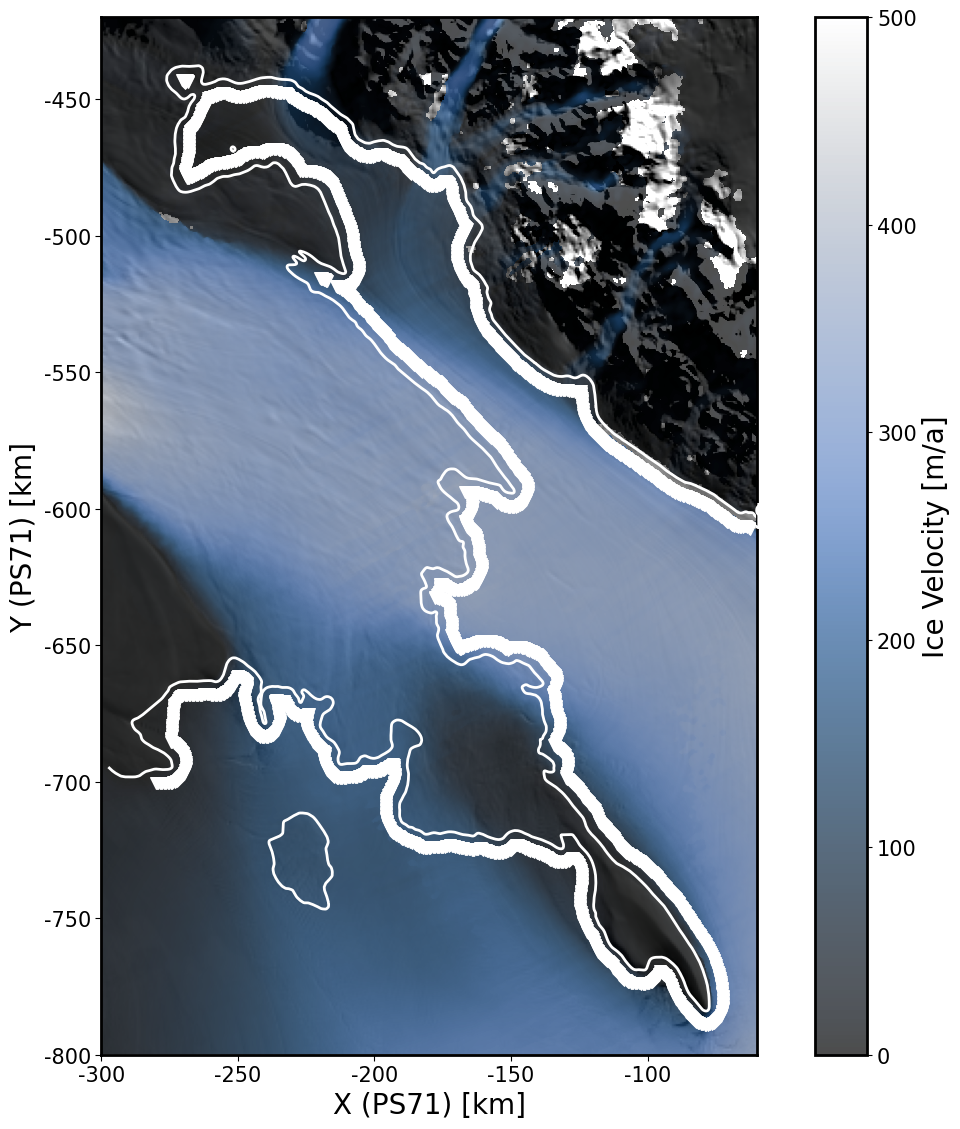

In [5]:
# Plot tide locations

vel_mag_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/antarctic_ice_vel_phase_map_v01-vmag.nc"
moa_path = (
    "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/moa750_2009_hp1_v1.1.tif"
)
vel_mag = xr.open_dataarray(vel_mag_path)
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
vel_mag = vel_mag.isel(x=slice(4000, 8000), y=slice(6000, 8000))
x_min_v, x_max_v = vel_mag["x"].min().item(), vel_mag["x"].max().item()
y_min_v, y_max_v = vel_mag["y"].min().item(), vel_mag["y"].max().item()

with rasterio.open(moa_path) as moa:
    bounds = moa.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
    moa_dat = moa.read(1)

ext = (left, right, bottom, top)


oslo = Colormap("crameri:oslo").to_mpl()
# Static frame
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 5, (bbox[3] - bbox[1]) / 100000 * 3]
)
fig.set_tight_layout(True)
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax, add_points=False, color="white")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel("X (PS71) [km]", size=20)
ax.set_ylabel("Y (PS71) [km]", size=20)
ax.tick_params(labelsize=15)
ax.tick_params(size=4)
# ax.set_facecolor("black")
cbarv = fig.colorbar(v)
cbarv.ax.tick_params(labelsize=15)
cbarv.ax.set_ylabel("Ice Velocity [m/a]", size=20)
x, y = ll2xy(lons, lats)
places = ["gz05", "North", "South"]
ax.scatter(x, y, s=70, color="white", marker="v")
print(x)
ax.text(x[0] + 2000, y[0], "gz05", color="white", size=25)
ax.text(x[1] + 2000, y[1], "North", color="white", size=25)
ax.text(x[2] + 2000, y[2], "South", color="white", size=25)

fig.tight_layout()

In [ ]:
# Tide time series at gz05 for diurnal, semiduirnal, 4 main, and 8 main
%autoreload

spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 12 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]

tide_arr = []
tides = Tides.Tide(tide_mod, tide_dir)
consts = [
    ["o1", "q1"],
    ["m2", "k1"],
    ["m2", "s2", "k1", "o1"],
    ["m2", "s2", "k1", "o1", "q1"],
    ["m2", "s2", "k1", "o1", "n2"],
    ["m2", "s2", "k1", "o1", "n2", "p1", "q1", "k2"],
]
for const in consts:
    for lat, lon, place in zip(lats, lons, places):
        td = tides.tidal_elevation([lon], [lat], dates_timeseries, consts=const).data.T[
            0
        ]
        tide_arr.append(td)

['o1' 'q1']
['m2' 'k1']
['m2' 's2' 'k1' 'o1']
['m2' 's2' 'k1' 'o1' 'q1']


In [ ]:
# Calculate modfied tidal form factor
# 3 days of tides with a 0.5 day slide

# Convert dates_timeseries to seconds since dates_timeseries[0]
seconds = [(date - dates_timeseries[0]).total_seconds() for date in dates_timeseries]

spacing = 4  # Minutes
mean_days = 3
slide_days = 1
mean_units = int(mean_days * 24 * 60 / spacing)
slide_units = int(slide_days * 24 * 60 / spacing)

HR_TO_SEC = 3600
T_O1 = 25.81933871 * HR_TO_SEC
T_K1 = 23.93447213 * HR_TO_SEC
T_M2 = 12.4206012 * HR_TO_SEC
T_S2 = 12 * HR_TO_SEC


def sines(x, A1, phi1, A2, phi2):
    return A1 * np.sin(2 * np.pi * x / ((T_O1 + T_K1) / 2) + phi1) + A2 * np.sin(
        2 * np.pi * x / ((T_M2 + T_S2) / 2) + phi2
    )


ff_arr = []
for tide_x in tide_arr:
    ff_dict = {
        "form_factor": [],
        "dates_form_factor": [],
        "semidiurnal": [],
        "diurnal": [],
    }
    # Extract 3 days of tidal data with a 0.5 day slide
    start = 0
    end = mean_units
    while end < len(seconds):
        seconds_tide = np.array(seconds[start:end], dtype=float)
        tide = np.array(tide_x[start:end], dtype=float)
        date_midpoint = dates_timeseries[(start + end) // 2]
        start += slide_units
        end += slide_units

        # Fit a sum of sines to the tide
        initial_guess = [50, 0, 50, 0]
        popt, pcov = scipy.optimize.curve_fit(
            sines, seconds_tide, tide, p0=initial_guess
        )

        # Extract fitted parameters
        Diurnal_fit, phi1_fit, SemiDiurnal_fit, phi2_fit = popt

        # Generate the fitted curve
        y_fit = sines(seconds_tide, Diurnal_fit, phi1_fit, SemiDiurnal_fit, phi2_fit)
        form_factor = np.abs(Diurnal_fit / SemiDiurnal_fit)
        ff_dict["form_factor"].append(form_factor)
        ff_dict["dates_form_factor"].append(date_midpoint)
        ff_dict["semidiurnal"].append(SemiDiurnal_fit)
        ff_dict["diurnal"].append(Diurnal_fit)

        # fig, ax = plt.subplots()
        # ax.plot(seconds_tide, tide, color="black")
        # ax.plot(seconds_tide, y_fit, color="red")
    ff_arr.append(ff_dict)

/tmp/ipykernel_139594/3596869607.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(sines, seconds_tide, tide, p0=initial_guess)


In [13]:
# Tides at event times
times_to_calculate_tide = ev_data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]

for lat, lon, place in zip(lats, lons, places):
    print(lat, lon, place)
    ev_data[f"tide_event_time_{place}"] = tides.tidal_elevation(
        [lon], [lat], dates, consts=["m2", "s2", "k1", "o1"]
    ).data.T[0]

-84.2986 -164.5206 gz05
['m2' 's2' 'k1' 'o1']


In [ ]:
# Calculate distance between event and nearest low and high tides
def dists(ev_data, place):
    # Calculate tidal maxima and minima for comparison

    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array

    # Get as indices
    pks = scipy.signal.find_peaks(ev_data[f"tides{place}"], distance=60 / spacing * 3)[
        0
    ]  # Require 5 hrs between peaks
    vlys = scipy.signal.find_peaks(
        -1 * ev_data[f"tides{place}"], distance=60 / spacing * 3
    )[0]  # Require 5 hrs between valleys

    # Also save as times
    pk_times = [dates_timeseries[pk] for pk in pks]
    vly_times = [dates_timeseries[vly] for vly in vlys]

    # Find skipped low tide events (No event within +- 7 hrs of vly)
    skipped_lows = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, vly in enumerate(vlys):
        valley = dates_timeseries[vly]
        closest_event = min(events, key=lambda d: abs(d - valley))
        skipped = -1
        if abs(closest_event - valley) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_lows.append(skipped)

    skipped_highs = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, pk in enumerate(pks):
        peak = dates_timeseries[pk]
        closest_event = min(events, key=lambda d: abs(d - peak))
        skipped = -1
        if abs(closest_event - peak) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_highs.append(skipped)

    vly_date = [dates_timeseries[vly] for vly in vlys]
    vly_tide = [ev_data[f"tides{place}"][vly] for vly in vlys]

    pk_date = [dates_timeseries[pk] for pk in pks]
    pk_tide = [ev_data[f"tides{place}"][pk] for pk in pks]

    dist_to_highs = []
    dist_to_lows = []
    closest_highs = []
    closest_lows = []
    high_closers = []
    ht_to_highs = []
    ht_to_lows = []
    high_ht_closers = []
    for i, event in enumerate(ev_data["ev_time"]):
        event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        closest_high = min(pk_times, key=lambda d: abs(d - event))
        dist_to_high = event - closest_high
        closest_low = min(vly_times, key=lambda d: abs(d - event))

        ht_to_high = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][pks[pk_times.index(closest_high)]]
        )
        ht_to_low = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][vlys[vly_times.index(closest_low)]]
        )
        ht_to_highs.append(ht_to_high)
        ht_to_lows.append(ht_to_low)

        dist_to_low = event - closest_low
        dist_to_highs.append(dist_to_high)
        dist_to_lows.append(dist_to_low)
        closest_highs.append(closest_high)
        closest_lows.append(closest_low)

        if abs(dist_to_high) < abs(dist_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_closers.append(high_closer)

        if abs(ht_to_high) < abs(ht_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_ht_closers.append(high_closer)

    dist_dict = {
        "dist_to_highs": dist_to_highs,
        "dist_to_lows": dist_to_lows,
        "closest_highs": closest_highs,
        "closest_lows": closest_lows,
        "high_closers": high_closers,
        "ht_to_highs": ht_to_highs,
        "ht_to_lows": ht_to_lows,
        "high_ht_closers": high_ht_closers,
        "vly_date": vly_date,
        "vly_tide": vly_tide,
        "pk_date": pk_date,
        "pk_tide": pk_tide,
    }
    return dist_dict

In [12]:
# Connect axes using https://matplotlib.org/stable/users/explain/text/annotations.html
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch,
    BboxConnector,
    BboxConnectorPatch,
)


def connect_bbox(
    bbox1, bbox2, loc1a, loc2a, loc1b, loc2b, prop_lines, prop_patches=None
):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1) * 0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(
        bbox1,
        bbox2,
        # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        loc1a=loc1a,
        loc2a=loc2a,
        loc1b=loc1b,
        loc2b=loc2b,
        **prop_patches,
    )
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    (xmin,xmax) : the limits of the colored area in both plot axes.

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches.

    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1,
        mybbox2,
        loc1a=3,
        loc2a=2,
        loc1b=4,
        loc2b=1,
        prop_lines=kwargs,
        prop_patches=prop_patches,
    )

    # ax1.add_patch(bbox_patch1)
    # ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

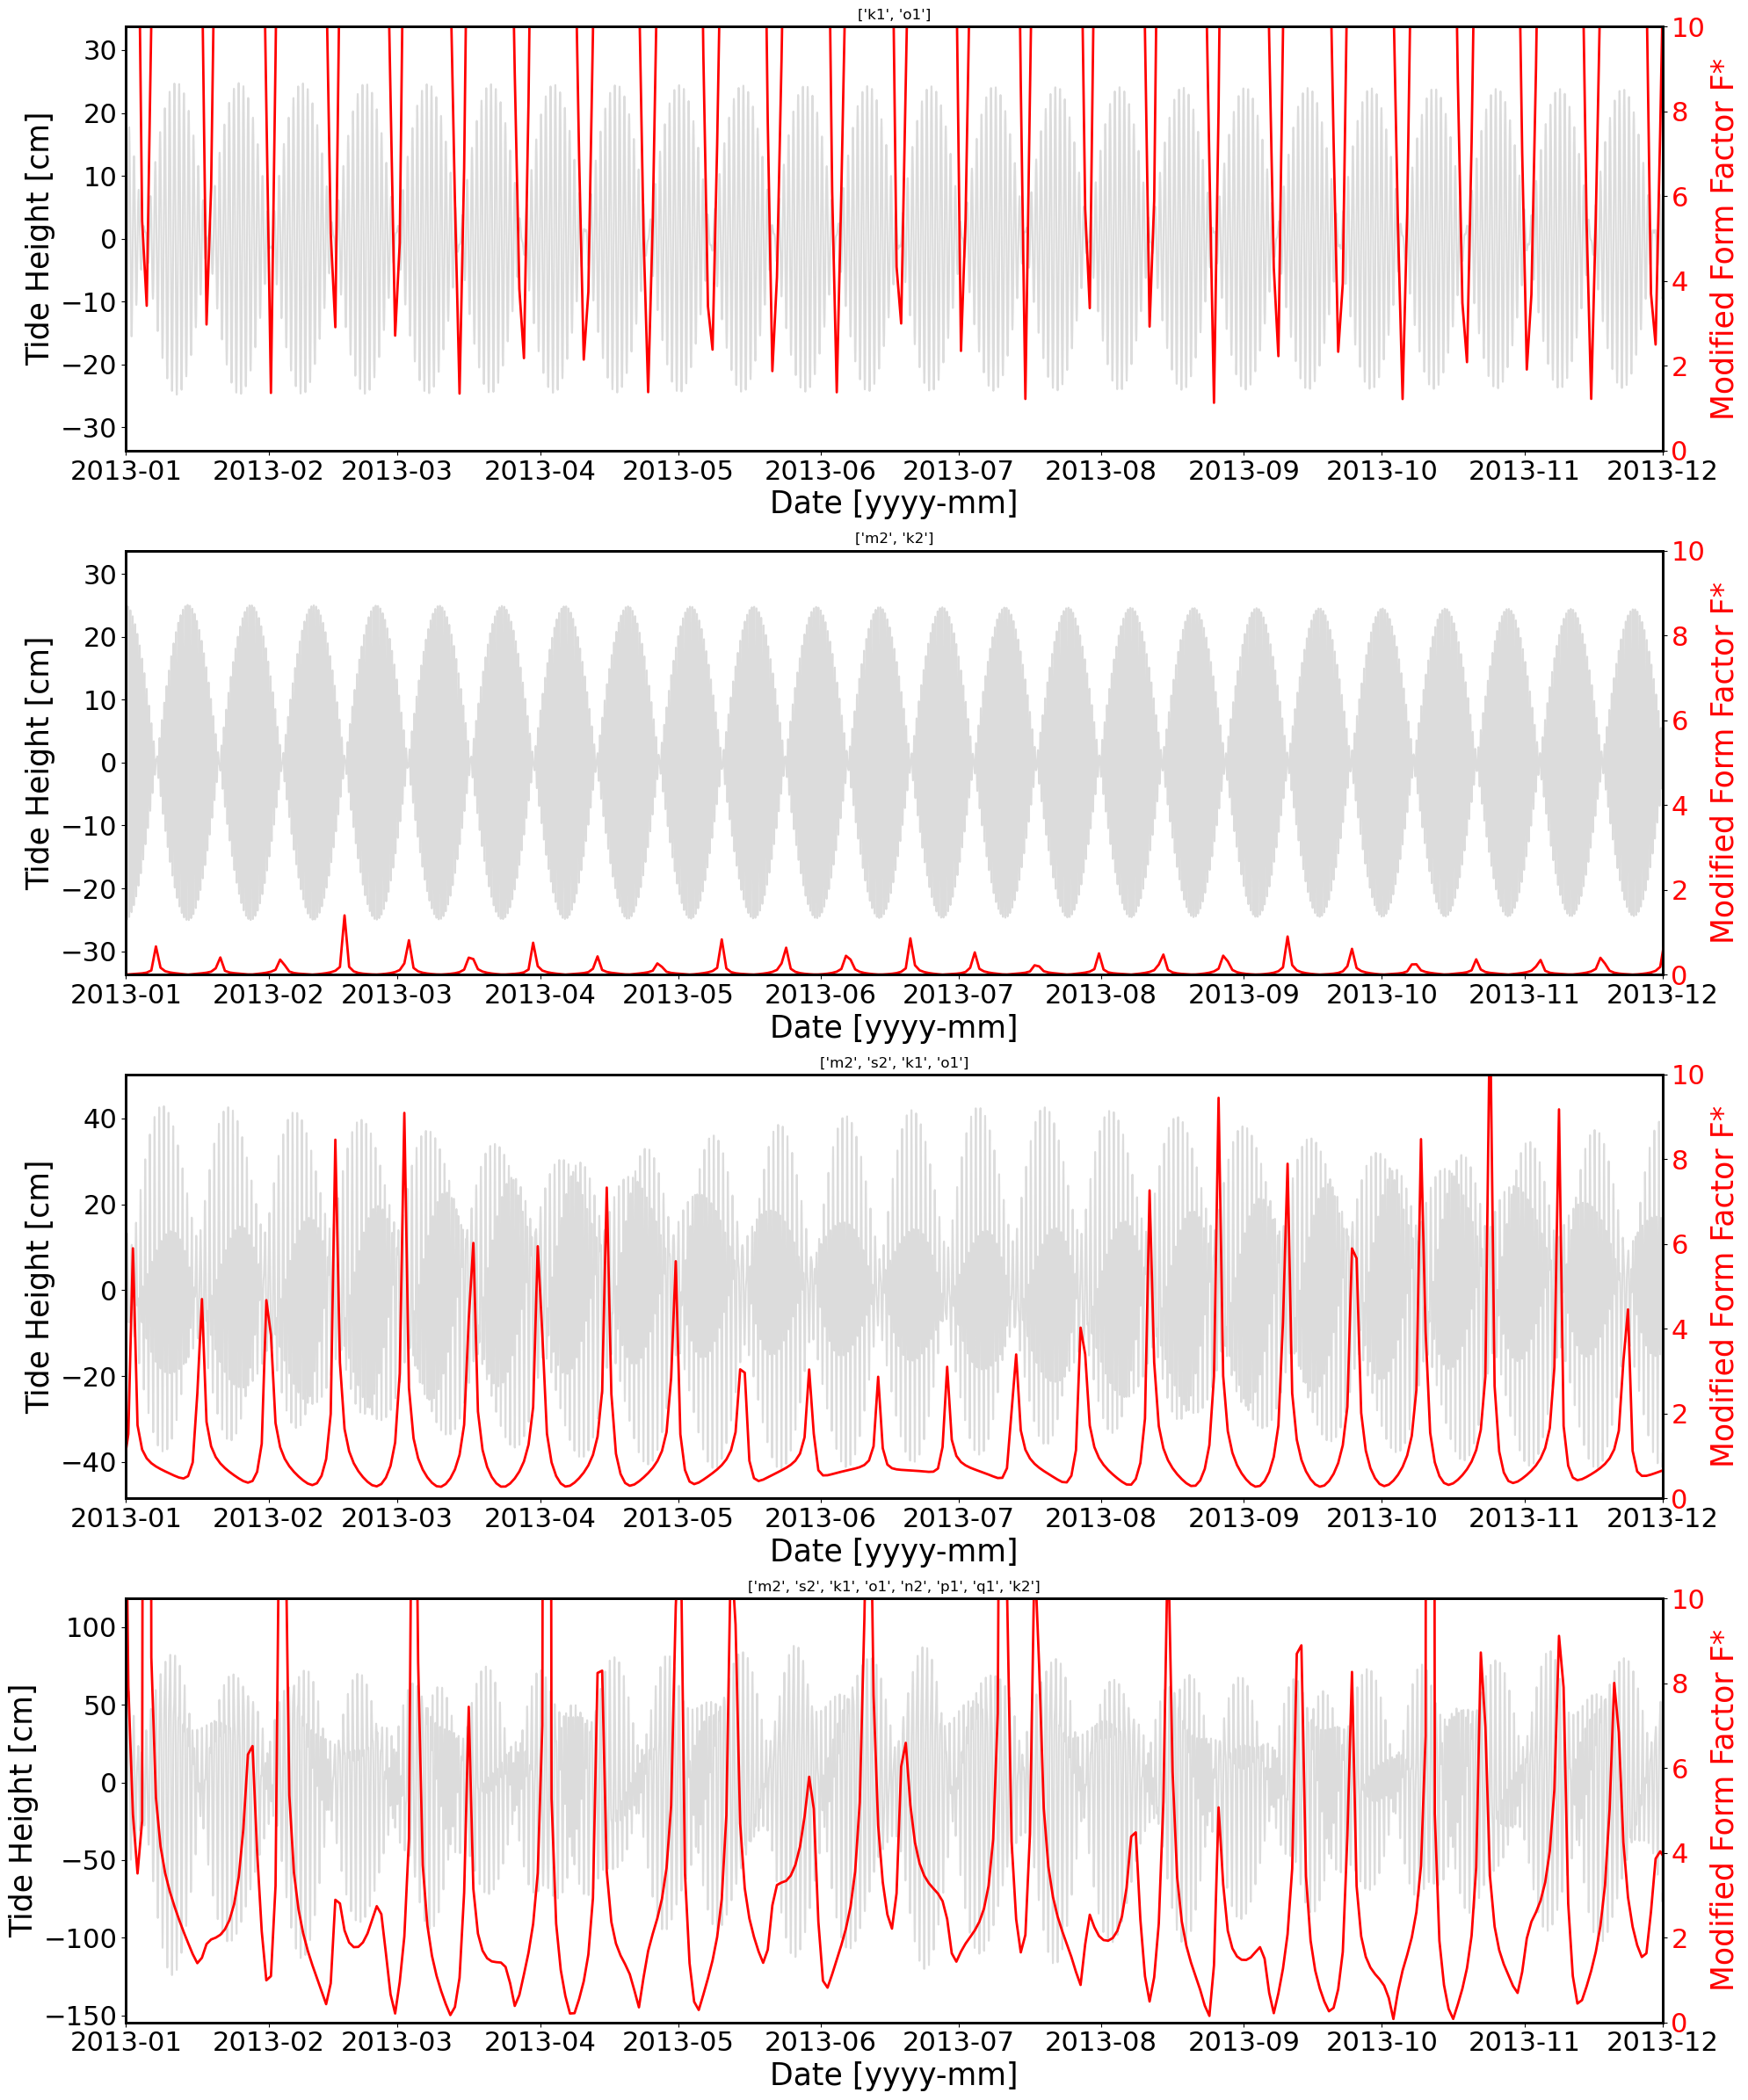

In [ ]:
# Plot tides to see trends with diurnal tides
def subplot(ax, place, form_factor, st, ed):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, place, zorder=0, color="gainsboro")
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=25)
    # Set x date format
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xlabel("Date [yyyy-mm]", size=25)

    ax_form_factor = ax.twinx()
    # ax_form_factor.plot(dates_form_factor, semidiurnal, color="red",linewidth=2)
    # ax_form_factor.plot(dates_form_factor, diurnal, color="blue",linewidth=2)
    ax_form_factor.plot(
        form_factor["dates_form_factor"],
        form_factor["form_factor"],
        color="red",
        linewidth=2,
    )
    ax_form_factor.set_ylabel("Modified Form Factor F*", size=25, color="red")
    # y ticks red
    ax_form_factor.tick_params(axis="y", labelcolor="red")
    ax_form_factor.set_ylim(0, 10)
    ax_form_factor.yaxis.set_tick_params(labelsize=22)

    ax.set_ylabel("Tide Height [cm]", size=25)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(4, 1, figsize=[20, 24])
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 12, 1)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for form_factor, tide, ax, ff_text in zip(ff_arr, tide_arr, axs, consts):
    subplot(ax, tide, form_factor, st, ed)
    ax.title.set_text(ff_text, size=25)

fig.tight_layout()